In [85]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
import os, sys, math
import numpy as np
import matplotlib.pyplot as plt
from argparse import Namespace
from tqdm.notebook import tqdm
from sklearn.metrics import explained_variance_score as var_exp

import torch 
from torch.utils.data import DataLoader


sys.path.append('../')
from utils.arg_parser import parse_exp_args
from utils.common import PlainDataset
from run import load_model

## Set options

In [359]:
# runid = 'fc_delta_full_pinj'
runid = 'cnn_delta_full_pinj_clean2'

dataset = 'cnn_delta_full_pinj_clean'

ep = 990
plot_train = True
device = 'cuda:7'
train_batch = 1024
# device = 'cpu'

In [360]:
pred_dir = '/home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/logs/{}'.format(runid)
data_dir = '/home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/data/{}'.format(dataset)

print(pred_dir)
print(data_dir)

/home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/logs/cnn_delta_full_pinj_clean2
/home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/data/cnn_delta_full_pinj_clean


### Load test points, and train points/model

In [361]:
test_preds = np.load(os.path.join(pred_dir, 'test_preds_ep_{}.npy'.format(ep)))
test_X = np.load(os.path.join(data_dir, 'test_X.npy'))
test_y = np.load(os.path.join(data_dir, 'test_y.npy'))
print('loaded test predictions and gt')
print(test_preds.shape, test_y.shape)
num_test = test_y.shape[0]

if plot_train:
    train_X = np.load(os.path.join(data_dir, 'train_X.npy'))
    train_y = np.load(os.path.join(data_dir, 'train_y.npy'))
    print('loaded train data')
    print(train_X.shape, train_y.shape)
    num_train = train_y.shape[0]

loaded test predictions and gt
(17317, 1) (17317, 1)
loaded train data
(156580, 12, 100) (156580, 1)


### (optional) see which test predictions are non zero

In [362]:
# non_zero = []
# for i in range(test_preds.shape[0]):
#     if test_preds[i] != 0:
#         non_zero.append(i)
# non_zero = np.array(non_zero)
# print(non_zero)
# print(test_preds[non_zero])
# print(test_preds[non_zero].min())

## load test model

In [363]:
if plot_train:
    args_file = os.path.join(pred_dir, 'args.txt')
    model_path = os.path.join(pred_dir, 'model_ep_{}'.format(ep))
    temp_args = parse_exp_args(args_file)
    temp_args.multi_gpu = False
    temp_args.device = device
    temp_args.model_path = model_path
#     temp_args = Namespace(model_path=model_path,
#                           device=device,
#                           multi_gpu=False)
    test_model = load_model(temp_args)
    test_model.eval()
    print('loaded model')
    train_dataset = PlainDataset(None, None, False, X_arr=train_X, y_arr=train_y)
    train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=False)

Loading model from /home/scratch/youngsec/rs/fusion/dynamics_models/NNKit/logs/cnn_delta_full_pinj_clean2/model_ep_990
input to conv1D of 12 channels * 100 signal length (1200 values)
output of conv1D of 64 channels * 91 signal length (5824 values), actv None
output of conv1D of 128 channels * 87 signal length (11136 values), actv None
output of conv1D of 128 channels * 83 signal length (10624 values), actv None
output of conv1D of 64 channels * 81 signal length (5184 values), actv None
output of conv1D of 32 channels * 79 signal length (2528 values), actv None
output of conv1D of 5 channels * 78 signal length (390 values), actv None
output of linear layer of 512 values, actv relu
output of linear layer of 512 values, actv relu
output of linear layer of 512 values, actv relu
output of linear layer of 512 values, actv relu
output of linear layer of 1 values, actv None
ModuleList(
  (0): Conv1DLayer(
    (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True

In [364]:
#list(test_model.named_parameters())

### Get training points

In [365]:
if plot_train:
    print('getting train predictions now')
    train_pred_list = []
    print('total iterations {}'.format(math.ceil(num_train/train_batch)))
    for idx, (curr_X, _) in tqdm(enumerate(train_loader)):
        with torch.no_grad():
            curr_X = curr_X.to(device)
            curr_preds = test_model(curr_X)
            train_pred_list.append(curr_preds.cpu().numpy())
    train_preds = np.concatenate(train_pred_list, axis=0)
    print(train_preds.shape)

getting train predictions now
total iterations 153



(156580, 1)


### check difference in test preds and test_model output on test_X are same

In [366]:
temp = test_model(torch.FloatTensor(test_X).to(device))
test_diff = temp.detach().cpu().numpy() - test_preds
print(test_diff.max(), test_diff.min())

1.4573336e-05 -1.40070915e-05


## Sort outputs for plot

In [367]:
test_y_order = np.argsort(test_y, axis=0).flatten()
print(test_y_order)
if plot_train:
    train_y_order = np.argsort(train_y, axis=0).flatten()
    print(train_y_order)

[ 5740 13506 13516 ...  5203  4663 13515]
[26794 17864  3110 ... 11190 32662 23915]


In [368]:
sorted_test_preds = test_preds[test_y_order]
sorted_test_y = test_y[test_y_order]
if plot_train:
    sorted_train_preds = train_preds[train_y_order]
    sorted_train_y = train_y[train_y_order]

### Plot test performance

MSE: 0.055563
Variance explained 0.144129


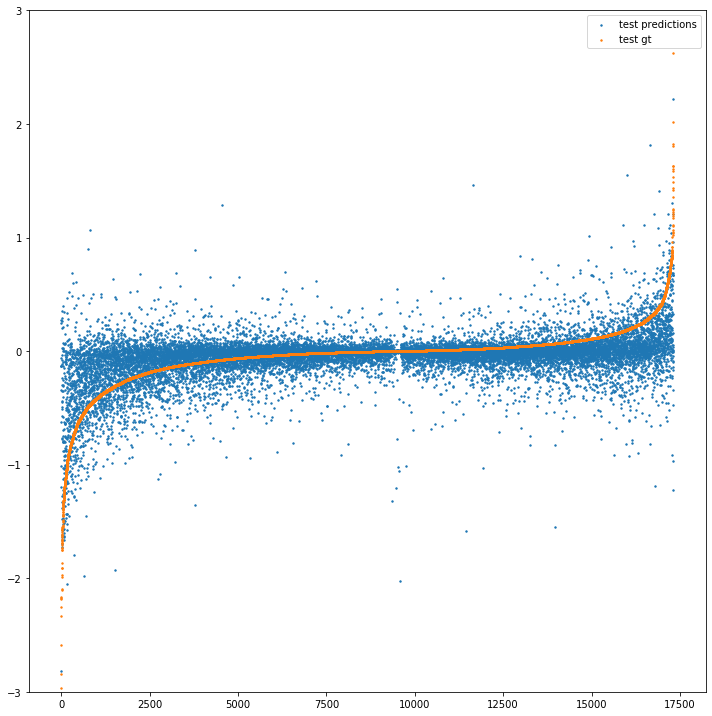

In [369]:
plt.scatter(np.arange(num_test), sorted_test_preds, label='test predictions', s=2)
plt.scatter(np.arange(num_test), sorted_test_y, label='test gt', s=2)

curr_MSE = np.mean((sorted_test_preds - sorted_test_y)**2)
print('MSE: {0:.6f}'.format(curr_MSE))
curr_var_exp = var_exp(sorted_test_y, sorted_test_preds)
print('Variance explained {0:.6f}'.format(curr_var_exp))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,10)

# # first 1000
# plt.xlim(0,1000)
# last 100
# plt.xlim(num_test-1000, num_test)
fig.tight_layout()
# fig.autoscale()
plt.ylim(-3,3)

plt.show()

In [370]:
test_preds.min(), test_preds.max()

(-2.8163857, 2.218045)

MSE: 0.0132526811
Variance explained 0.784436


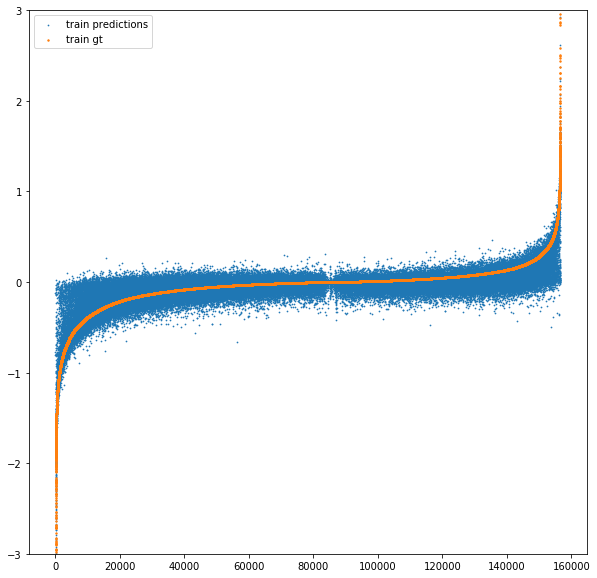

In [373]:
plt.scatter(np.arange(num_train), sorted_train_preds, label='train predictions', s=0.5)
plt.scatter(np.arange(num_train), sorted_train_y, label='train gt', s=2)
curr_MSE = np.mean((sorted_train_preds - sorted_train_y)**2)
print('MSE: {0:.10f}'.format(curr_MSE))
curr_var_exp = var_exp(sorted_train_y, sorted_train_preds)
print('Variance explained {0:.6f}'.format(curr_var_exp))
plt.legend()
fig = plt.gcf()
fig.set_size_inches(10,10)

# # first 100
# plt.xlim(0,100)
# last 100
# plt.xlim(num_train-100, num_train)
# plt.ylim(-1.2, 1.2)
plt.ylim(-3, 3)

plt.show()

In [372]:
sorted_train_preds.min(), sorted_train_preds.max()

(-3.3854547, 3.3793135)

In [29]:
test_model

cnn(
  (loss): MSELoss()
  (layers): ModuleList(
    (0): Conv1DLayer(
      (pool): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Conv1DLayer(
      (pool): MaxPool1d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
    )
    (2): Conv1DLayer(
      (pool): AvgPool1d(kernel_size=(3,), stride=(1,), padding=(0,))
    )
    (3): Conv1DLayer(
      (pool): AvgPool1d(kernel_size=(2,), stride=(1,), padding=(0,))
    )
    (4): LinearLayer(
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SELU(inplace=True)
    )
    (5): LinearLayer(
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SELU(inplace=True)
    )
    (6): LinearLayer(
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): SELU(inplace=True)
    )
    (7): LinearLayer(
      (activation): R

### (optional) calculating number of outliers

In [36]:
num_out = 0
for i in train_y:
    if np.abs(i) > 3.4:
#         print(i)
        num_out += 1
print(num_out, 100*num_out/num_train)

2 0.0012773023374632775


In [38]:
num_out = 0
for i in test_y:
    if np.abs(i) > 3.4:
#         print(i)
        num_out += 1
print(num_out, 100*num_out/num_test)

2 0.011549344574695386


In [16]:
test_z = (test_y - np.mean(test_y))/np.std(test_y)

In [18]:
np.sum(np.abs(test_z)>3 )/num_test

0.00554048594678825

In [24]:
test_y[np.abs(test_z)>3].size

96

In [22]:
np.abs(test_y[np.abs(test_z)>3]).min()

1.2456196956933563

In [16]:
test_y.shape

(17327, 1)

In [287]:
total_params = 0
for x in test_model.parameters():
#     print(len(x))
    curr_params = np.prod(list(x.shape)) 
#     print(curr_params)
    total_params += curr_params
print(total_params)

1152769


In [317]:
in_dim = 1200

In [329]:
k = 8.7
print(2**k)

415.8732269343924


In [330]:
(total_params - (2**k * (in_dim+3)))/(2**(2*k) + 2**k)

3.7635519622178335